# Trader Behavior vs Market Sentiment Analysis

## Sentiment-Aware Trading Behavior Study using Hyperliquid Data

### Sentiment Classification Update

The original Fear & Greed Index provides four sentiment categories:
- Extreme Fear
- Fear
- Neutral
- Greed
- Extreme Greed

Instead of collapsing sentiment into a binary classification, this analysis
preserves all four classes to capture nuanced trader behavior and hidden risk signals.
A secondary binary grouping is derived later for high-level comparison.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os

In [ ]:
# Create required directories if they don't exist
os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

print("Project folders created: csv_files/, outputs/")


Project folders created: csv_files/, outputs/


Downloading Files from Google drive

In [ ]:
import gdown

fear_greed_id = '1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'
historical_data_id = '1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs'

gdown.download(f'https://drive.google.com/uc?id={fear_greed_id}', 'fear_greed_index.csv', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={historical_data_id}', 'historical_data.csv', quiet=False)

print('Files downloaded successfully!')

Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_index.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 66.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_data.csv
100%|██████████| 47.5M/47.5M [00:01<00:00, 46.3MB/s]

Files downloaded successfully!


Loading files

In [ ]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")

In [ ]:
# Data set Processing
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['sentiment'] = sentiment_df['classification'].str.title()

In [ ]:
# Time Handling
trades_df['Timestamp IST'] = pd.to_datetime(
    trades_df['Timestamp IST'], format="%d-%m-%Y %H:%M"
)

trades_df['date'] = trades_df['Timestamp IST'].dt.date
trades_df['date'] = pd.to_datetime(trades_df['date'])

# Normalising PnL
trades_df['Closed PnL'] = trades_df['Closed PnL'].fillna(0)

trades_df['trade_volume'] = trades_df['Execution Price'] * abs(trades_df['Size Tokens'])
trades_df['is_profitable'] = trades_df['Closed PnL'] > 0

In [ ]:
# Merging Trader data and sentiments
merged_df = trades_df.merge(
    sentiment_df[['date', 'sentiment']],
    on='date',
    how='inner'
)

In [ ]:
# Save merged CSV
merged_df.to_csv("csv_files/merged_data.csv", index=False)

In [ ]:
# Behavior vs Sentiment
summary = merged_df.groupby('sentiment').agg(
    avg_pnl=('Closed PnL', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    avg_volume=('trade_volume', 'mean'),
    win_rate=('is_profitable', 'mean'),
    trade_count=('Closed PnL', 'count')
).reset_index()

In [ ]:
# Save summary to csv
summary.to_csv("csv_files/summary_metrics.csv", index=False)

### Visualizations

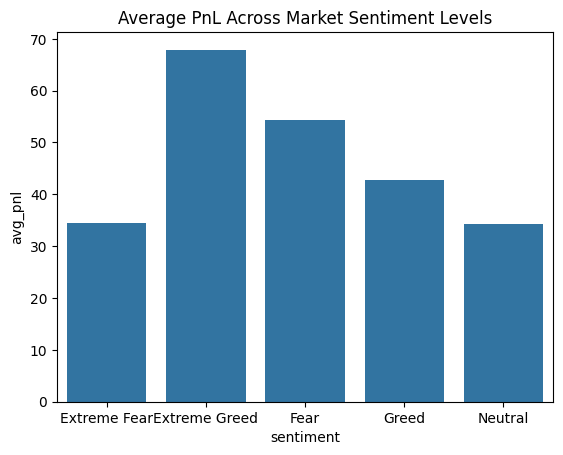

In [ ]:
# Average Profitability
sns.barplot(data=summary, x='sentiment', y='avg_pnl')
plt.title("Average PnL Across Market Sentiment Levels")
plt.savefig("outputs/avg_pnl_by_sentiment.png")
plt.show()

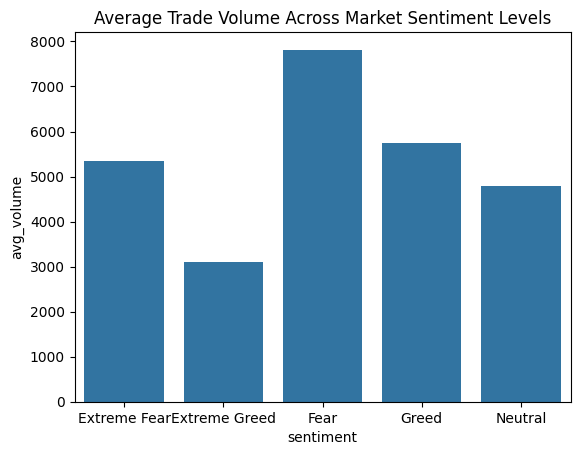

In [ ]:
# Trading Volume
sns.barplot(data=summary, x='sentiment', y='avg_volume')
plt.title("Average Trade Volume Across Market Sentiment Levels")
plt.savefig("outputs/avg_volume_by_sentiment.png")
plt.show()

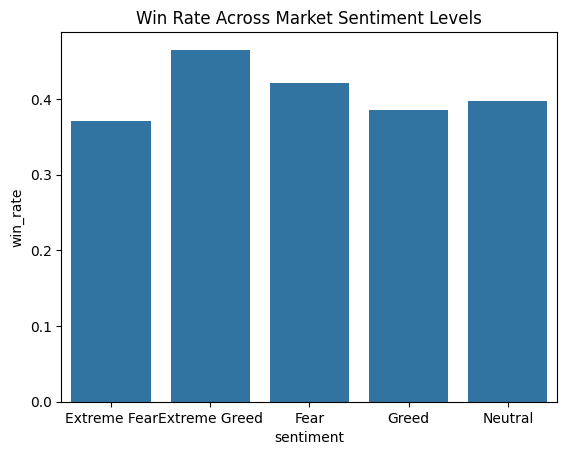

In [ ]:
# Win Rate
sns.barplot(data=summary, x='sentiment', y='win_rate')
plt.title("Win Rate Across Market Sentiment Levels")
plt.savefig("outputs/win_rate_by_sentiment.png")
plt.show()

Hidden Risk Signal Detection

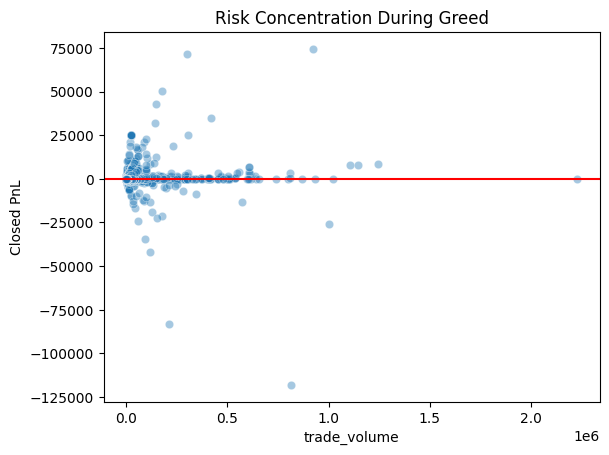

In [ ]:
# Volatility during Greed
greed_df = merged_df[merged_df['sentiment'] == 'Greed']

sns.scatterplot(
    data=greed_df,
    x='trade_volume',
    y='Closed PnL',
    alpha=0.4
)
plt.axhline(0, color='red')
plt.title("Risk Concentration During Greed")
plt.savefig("outputs/greed_risk_scatter.png")
plt.show()

In [ ]:
# Risk-Adjusted Performance
merged_df['risk_adjusted_pnl'] = (
    merged_df['Closed PnL'] / (merged_df['trade_volume'] + 1)
)

merged_df.groupby('sentiment')['risk_adjusted_pnl'].mean()

,risk_adjusted_pnl
sentiment,
Extreme Fear,0.004281
Extreme Greed,0.039825
Fear,0.015270
Greed,0.019381
Neutral,0.010111


Binary Sentiment

In [ ]:
merged_df['sentiment_binary'] = merged_df['sentiment'].map({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Neutral': 'Neutral',
    'Greed': 'Greed',
    'Extreme Greed': 'Greed'
})

merged_df.groupby('sentiment_binary')['Closed PnL'].mean()

,Closed PnL
sentiment_binary,
Fear,49.212077
Greed,53.882281
Neutral,34.307718
